<a href="https://colab.research.google.com/github/asolovyevv/projectii/blob/main/weatherAUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт модулей

In [ ]:
pip install catboost

In [ ]:
import pandas as pd

import numpy as np
from scipy import stats

import time

import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")


from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import svm

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,confusion_matrix


import pickle


# Обзор данных

In [ ]:
url = "/content/weatherAUS.csv"
wth = pd.read_csv(url)
wth.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
print("Rows & columns:" , wth.shape[0], "&", wth.shape[1])
print("Column names:" , [names for names in wth.columns])

Rows & columns: 32897 & 23
Column names: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


# Предварительная обработка данных

In [ ]:
wth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32897 entries, 0 to 32896
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           32897 non-null  object 
 1   Location       32897 non-null  object 
 2   MinTemp        32398 non-null  float64
 3   MaxTemp        32527 non-null  float64
 4   Rainfall       32210 non-null  float64
 5   Evaporation    13825 non-null  float64
 6   Sunshine       9380 non-null   float64
 7   WindGustDir    28030 non-null  object 
 8   WindGustSpeed  28034 non-null  float64
 9   WindDir9am     28429 non-null  object 
 10  WindDir3pm     30797 non-null  object 
 11  WindSpeed9am   32068 non-null  float64
 12  WindSpeed3pm   31422 non-null  float64
 13  Humidity9am    32231 non-null  float64
 14  Humidity3pm    31567 non-null  float64
 15  Pressure9am    26213 non-null  float64
 16  Pressure3pm    26217 non-null  float64
 17  Cloud9am       17086 non-null  float64
 18  Cloud3

Сверху мы видим, что в некоторых столбцах много пропущенных значений. Итак, давайте посмотрим на них как количественно, так и визуально.

In [ ]:
# Отсутствующие значения в процентах
(wth.isnull().sum())*100/(len(wth))

Date              0.000000
Location          0.000000
MinTemp           1.516856
MaxTemp           1.124723
Rainfall          2.088336
Evaporation      57.974891
Sunshine         71.486762
WindGustDir      14.794662
WindGustSpeed    14.782503
WindDir9am       13.581786
WindDir3pm        6.383561
WindSpeed9am      2.519987
WindSpeed3pm      4.483692
Humidity9am       2.024501
Humidity3pm       4.042922
Pressure9am      20.317962
Pressure3pm      20.305803
Cloud9am         48.062133
Cloud3pm         49.062225
Temp9am           1.328389
Temp3pm           3.358969
RainToday         2.088336
RainTomorrow      2.088336
dtype: float64

<Axes: >

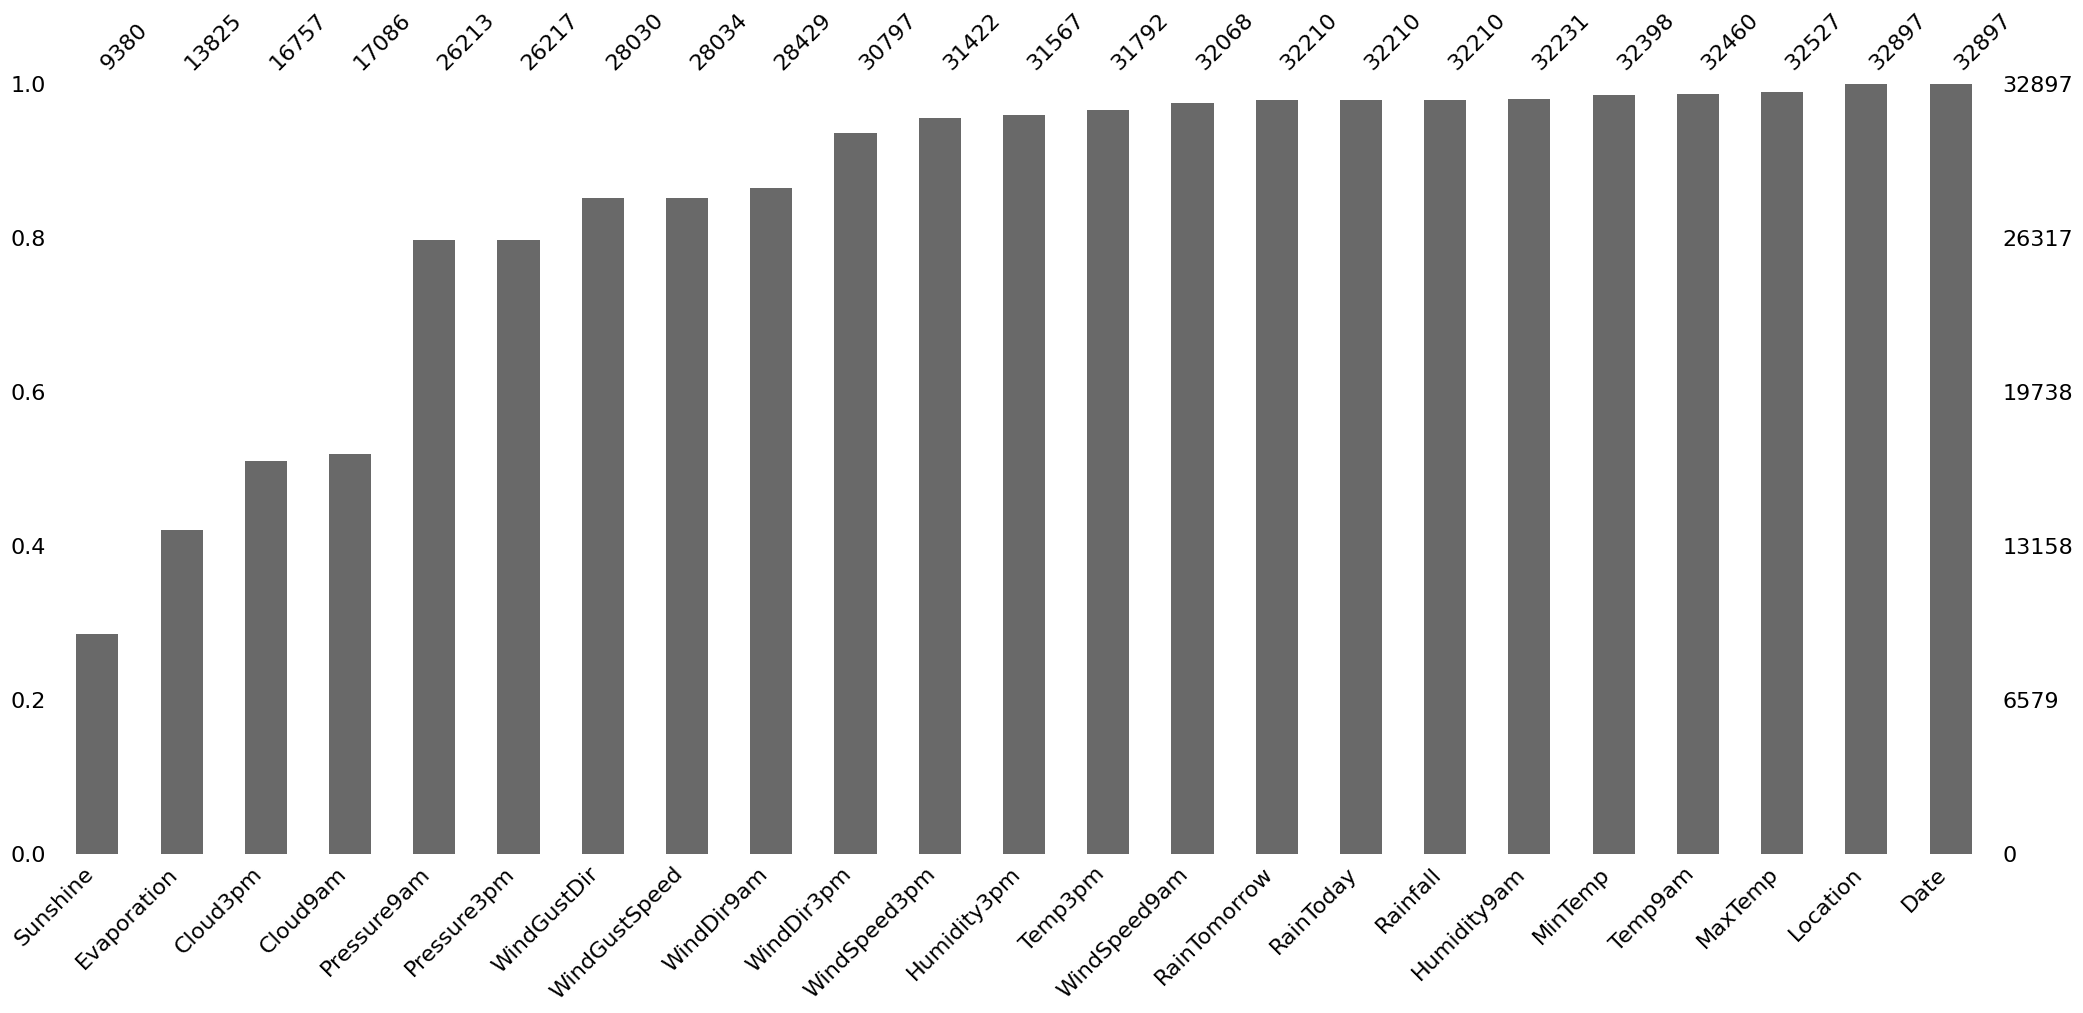

In [ ]:
# Отсутствующие значения визуально
msno.bar(wth, sort='ascending')

## Классификация по категориальным и числовым признакам

In [ ]:
# Категориальные и числовые данные
cate_data = [feature for feature in wth.columns if wth[feature].dtypes=="object"]
num_data = [feature for feature in wth.columns if feature not in cate_data]

print("Categorical Data Columns:", cate_data)
print("Numerical Data Columns:", num_data)

Categorical Data Columns: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
Numerical Data Columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


## Очистка числовых данных

### Интерполяция и импуляция

In [ ]:
no_intpol = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
intpol = [features for features in num_data if features not in no_intpol]

#### Интерполяция функций intpol

In [ ]:
intpol

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [ ]:
for feature in intpol:
  wth[feature] = wth[feature].interpolate()

In [ ]:
# Проверяем, есть ли нули
for feature in intpol:
  print(f"{feature} : {wth[feature].isnull().sum()*100/len(wth)}")

MinTemp : 0.0
MaxTemp : 0.0
Rainfall : 0.0
WindGustSpeed : 0.0
WindSpeed9am : 0.0
WindSpeed3pm : 0.0
Humidity9am : 0.0
Humidity3pm : 0.0
Pressure9am : 0.0
Pressure3pm : 0.0
Temp9am : 0.0
Temp3pm : 0.0


#### Простая импуляция no_intpol

In [ ]:
no_intpol

['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']

In [ ]:
sim_imputer = SimpleImputer(strategy="mean")

In [ ]:
for feature in no_intpol:
  X = wth.iloc[:,wth.columns.get_loc(feature)].values
  X = X.reshape(-1,1)
  wth[feature] = sim_imputer.fit_transform(X)

In [ ]:
# Проверяем, есть ли нули
for feature in no_intpol:
  print(f"{feature} : {wth[feature].isnull().sum()*100/len(wth)}")

Evaporation : 0.0
Sunshine : 0.0
Cloud9am : 0.0
Cloud3pm : 0.0


### Проверяем нули в num_data

In [ ]:
for feature in num_data:
  print(f"{feature} : {wth[feature].isnull().sum()*100/len(wth)}")

MinTemp : 0.0
MaxTemp : 0.0
Rainfall : 0.0
Evaporation : 0.0
Sunshine : 0.0
WindGustSpeed : 0.0
WindSpeed9am : 0.0
WindSpeed3pm : 0.0
Humidity9am : 0.0
Humidity3pm : 0.0
Pressure9am : 0.0
Pressure3pm : 0.0
Cloud9am : 0.0
Cloud3pm : 0.0
Temp9am : 0.0
Temp3pm : 0.0


In [ ]:
num_df = pd.DataFrame(wth[num_data])
num_df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,5.614676,7.623433,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.425554,16.9,21.8
1,7.4,25.1,0.0,5.614676,7.623433,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.316282,4.425554,17.2,24.3
2,12.9,25.7,0.0,5.614676,7.623433,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.316282,2.000000,21.0,23.2
3,9.2,28.0,0.0,5.614676,7.623433,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.316282,4.425554,18.1,26.5
4,17.5,32.3,1.0,5.614676,7.623433,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7


In [ ]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32897 entries, 0 to 32896
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        32897 non-null  float64
 1   MaxTemp        32897 non-null  float64
 2   Rainfall       32897 non-null  float64
 3   Evaporation    32897 non-null  float64
 4   Sunshine       32897 non-null  float64
 5   WindGustSpeed  32897 non-null  float64
 6   WindSpeed9am   32897 non-null  float64
 7   WindSpeed3pm   32897 non-null  float64
 8   Humidity9am    32897 non-null  float64
 9   Humidity3pm    32897 non-null  float64
 10  Pressure9am    32897 non-null  float64
 11  Pressure3pm    32897 non-null  float64
 12  Cloud9am       32897 non-null  float64
 13  Cloud3pm       32897 non-null  float64
 14  Temp9am        32897 non-null  float64
 15  Temp3pm        32897 non-null  float64
dtypes: float64(16)
memory usage: 4.0 MB


## Обработка категориальных данных

### Очистка категориальных данных

In [ ]:
cate_data

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']


#### Номинальный тип данных

Отображение, интерполяция и режим

In [ ]:
# Мэппинг

wth_map = {"Yes":1,"No":0}

wth["RainToday"] = wth["RainToday"].map(wth_map)
wth["RainTomorrow"] = wth["RainTomorrow"].map(wth_map)

In [ ]:
# Интерполяция

wth["RainToday"] = wth["RainToday"].interpolate(limit=3)
wth["RainTomorrow"] = wth["RainTomorrow"].interpolate(limit=3)

In [ ]:
# Обратное сопоставление

wth_reverse_map = {1:"Yes",0:"No"}

wth["RainToday"] = wth["RainToday"].map(wth_reverse_map)
wth["RainTomorrow"] = wth["RainTomorrow"].map(wth_reverse_map)

In [ ]:
# Замена оставшихся нулей на mode

wth["RainToday"] = wth["RainToday"].fillna(wth["RainToday"].mode()[0])
wth["RainTomorrow"] = wth["RainTomorrow"].fillna(wth["RainTomorrow"].mode()[0])

#### Порядковый тип данных


Замена нулей

In [ ]:
# Для оставшегося категориального признака (порядкового номера) мы будем использовать режим для заполнения нулей

cate_data_ordinal = ["WindGustDir", "WindDir9am","WindDir3pm"]

for feature in cate_data_ordinal:
  wth[feature] = wth[feature].fillna(wth[feature].mode()[0])

In [ ]:
# Проверка, есть ли у нас нули в данных порядкового типа

for feature in cate_data_ordinal:
   print(f"{feature} : {wth[feature].isnull().sum()*100/len(wth)}")

WindGustDir : 0.0
WindDir9am : 0.0
WindDir3pm : 0.0



### Проверка нулей в cate_data

In [ ]:
# Давайте проверим, есть ли у нас нули в cate_data

for feature in cate_data:
   print(f"{feature} : {wth[feature].isnull().sum()*100/len(wth)}")

Date : 0.0
Location : 0.0
WindGustDir : 0.0
WindDir9am : 0.0
WindDir3pm : 0.0
RainToday : 0.0
RainTomorrow : 0.0


In [ ]:
cate_df = pd.DataFrame(wth[cate_data])
cate_df.head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No



### Удаление столбца «Дата»

In [ ]:
wth_nd = wth.drop(["Date"],axis=1)


### Кодирование меток категориальных данных

In [ ]:
cate_data

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [ ]:
wth_nd.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,5.614676,7.623433,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.000000,4.425554,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,5.614676,7.623433,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,4.316282,4.425554,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,5.614676,7.623433,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,4.316282,2.000000,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,5.614676,7.623433,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,4.316282,4.425554,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,5.614676,7.623433,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No


In [ ]:
wth_nd_cate =  [feature for feature in wth_nd.columns if wth_nd[feature].dtypes=="object"]
wth_nd_cate

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [ ]:
# Проверка количество и уникальность значений перед кодированием меток

for feature in wth_nd_cate:
  print(f"{feature} : -")
  print(f"Value Counts:\n{wth_nd[feature].value_counts()}")
  print(f"\nUniques:\n{wth_nd[feature].unique()}")
  print("------------------------------")

Location : -
Value Counts:
Albury           3040
Newcastle        3039
Penrith          3039
BadgerysCreek    3009
Cobar            3009
CoffsHarbour     3009
Moree            3009
NorfolkIsland    3009
Richmond         3009
NorahHead        3004
Sydney           2721
Name: Location, dtype: int64

Uniques:
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney']
------------------------------
WindGustDir : -
Value Counts:
NNE    7132
NE     2243
SW     2129
ENE    2052
W      2047
E      2042
S      1980
SSW    1948
WSW    1889
SE     1692
SSE    1675
ESE    1598
WNW    1475
N      1260
NW      972
NNW     763
Name: WindGustDir, dtype: int64

Uniques:
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW']
------------------------------
WindDir9am : -
Value Counts:
SW     7125
W      2138
SSW    2134
NNE    2058
N      2023
NE     1960
SE     1913
S      1765
E      1745
NW     1679
W

In [ ]:
le_loc = preprocessing.LabelEncoder()
le_wind_gust = preprocessing.LabelEncoder()
le_dir9 = preprocessing.LabelEncoder()
le_dir3= preprocessing.LabelEncoder()
le_rain_tod = preprocessing.LabelEncoder()
le_rain_tom = preprocessing.LabelEncoder()

In [ ]:
wth_nd["Location"]=le_loc.fit_transform(wth_nd["Location"])
wth_nd["WindGustDir"]=le_wind_gust.fit_transform(wth_nd["WindGustDir"])
wth_nd["WindDir9am"]=le_dir9.fit_transform(wth_nd["WindDir9am"])
wth_nd["WindDir3pm"]=le_dir3.fit_transform(wth_nd["WindDir3pm"])
wth_nd["RainToday"]=le_rain_tod.fit_transform(wth_nd["RainToday"])
wth_nd["RainTomorrow"]=le_rain_tom.fit_transform(wth_nd["RainTomorrow"])

In [ ]:
# Проверка количества и уникальности значений после кодирования метки

for feature in wth_nd_cate:
  print(f"{feature} : -")
  print(f"Value Counts:\n{wth_nd[feature].value_counts()}")
  print(f"\nUniques:\n{wth_nd[feature].unique()}")
  print("------------------------------")

Location : -
Value Counts:
0     3040
5     3039
8     3039
1     3009
2     3009
3     3009
4     3009
7     3009
9     3009
6     3004
10    2721
Name: Location, dtype: int64

Uniques:
[ 0  1  2  3  4  5  6  7  8  9 10]
------------------------------
WindGustDir : -
Value Counts:
5     7132
4     2243
12    2129
1     2052
13    2047
0     2042
8     1980
11    1948
15    1889
9     1692
10    1675
2     1598
14    1475
3     1260
7      972
6      763
Name: WindGustDir, dtype: int64

Uniques:
[13 14 15  4  6  3  5 12  1 10  8  7  9  2  0 11]
------------------------------
WindDir9am : -
Value Counts:
12    7125
13    2138
11    2134
5     2058
3     2023
4     1960
9     1913
8     1765
0     1745
7     1679
15    1619
10    1470
2     1392
1     1374
14    1354
6     1148
Name: WindDir9am, dtype: int64

Uniques:
[13  6  9  1 12 10  8  4 11  3 15  2  0  7 14  5]
------------------------------
WindDir3pm : -
Value Counts:
9     5162
4     2963
0     2340
8     2210
1     1970
2     1


## Проверка информации о датафрейме

In [ ]:
wth_nd.head(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,13.4,22.9,0.6,5.614676,7.623433,13,44.0,13,14,...,71.0,22.0,1007.7,1007.1,8.000000,4.425554,16.9,21.8,0,0
1,0,7.4,25.1,0.0,5.614676,7.623433,14,44.0,6,15,...,44.0,25.0,1010.6,1007.8,4.316282,4.425554,17.2,24.3,0,0
2,0,12.9,25.7,0.0,5.614676,7.623433,15,46.0,13,15,...,38.0,30.0,1007.6,1008.7,4.316282,2.000000,21.0,23.2,0,0
3,0,9.2,28.0,0.0,5.614676,7.623433,4,24.0,9,0,...,45.0,16.0,1017.6,1012.8,4.316282,4.425554,18.1,26.5,0,0
4,0,17.5,32.3,1.0,5.614676,7.623433,13,41.0,1,7,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0


In [ ]:
(wth_nd.isnull().sum())*100/(len(wth))

Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [ ]:
wth_nd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32897 entries, 0 to 32896
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       32897 non-null  int64  
 1   MinTemp        32897 non-null  float64
 2   MaxTemp        32897 non-null  float64
 3   Rainfall       32897 non-null  float64
 4   Evaporation    32897 non-null  float64
 5   Sunshine       32897 non-null  float64
 6   WindGustDir    32897 non-null  int64  
 7   WindGustSpeed  32897 non-null  float64
 8   WindDir9am     32897 non-null  int64  
 9   WindDir3pm     32897 non-null  int64  
 10  WindSpeed9am   32897 non-null  float64
 11  WindSpeed3pm   32897 non-null  float64
 12  Humidity9am    32897 non-null  float64
 13  Humidity3pm    32897 non-null  float64
 14  Pressure9am    32897 non-null  float64
 15  Pressure3pm    32897 non-null  float64
 16  Cloud9am       32897 non-null  float64
 17  Cloud3pm       32897 non-null  float64
 18  Temp9a


## Удаление выбросов

In [ ]:
wth_nd_continuous_feature = [feature for feature in num_data if len(wth_nd[feature].unique())>25]
wth_nd_continuous_feature

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']


### Проверка данных перед удалением выбросов

In [ ]:
print('Форма wth_nd перед удалением выбросов', wth_nd.shape )

Shape of wth_nd before removing outliers (32897, 22)


### По Z-оценке

In [ ]:
wth_nd_continuous_feature

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

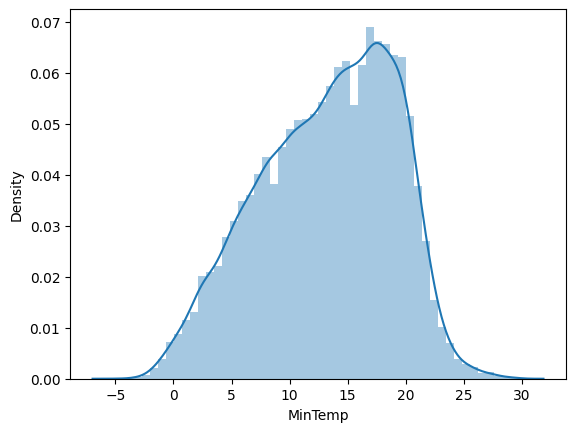

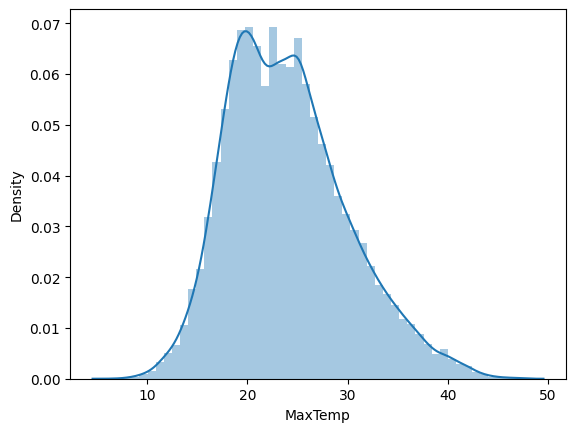

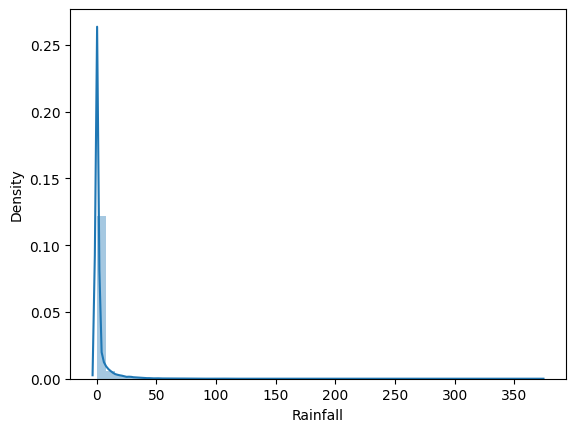

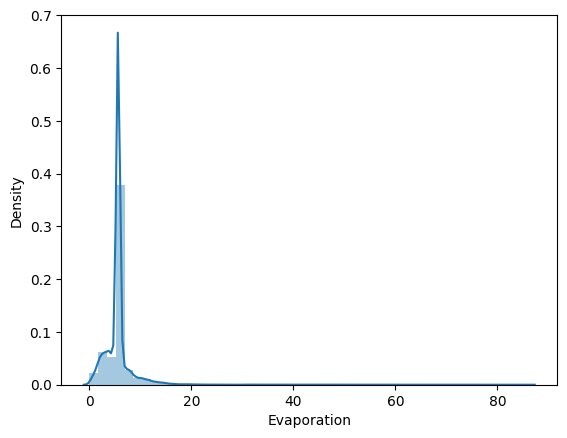

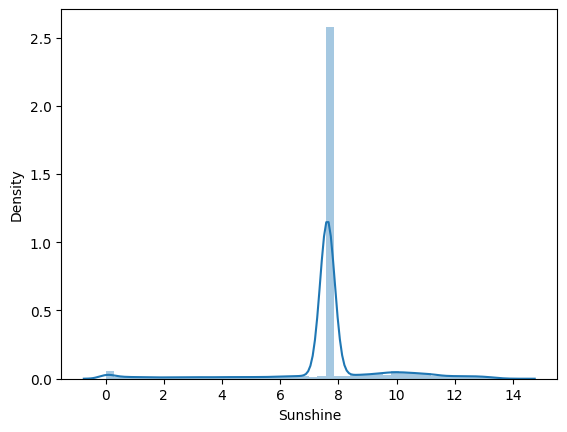

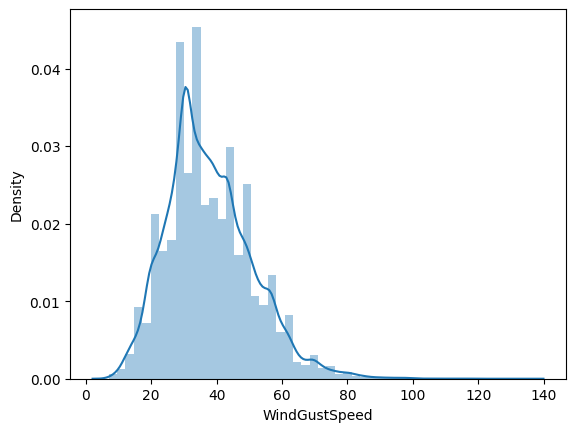

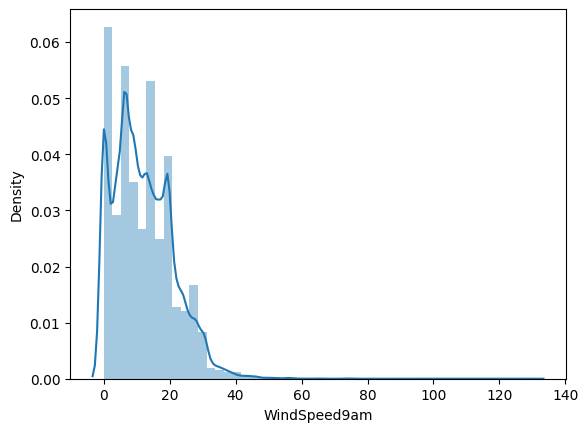

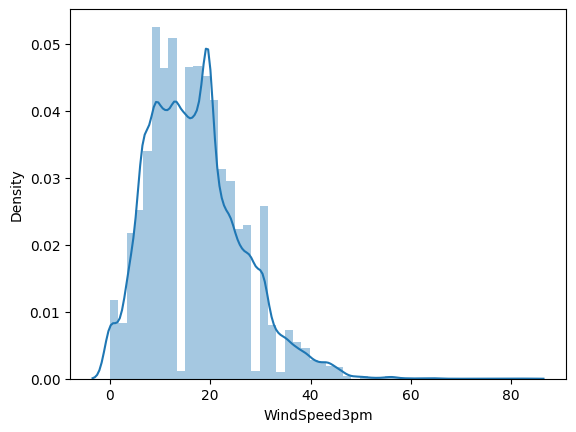

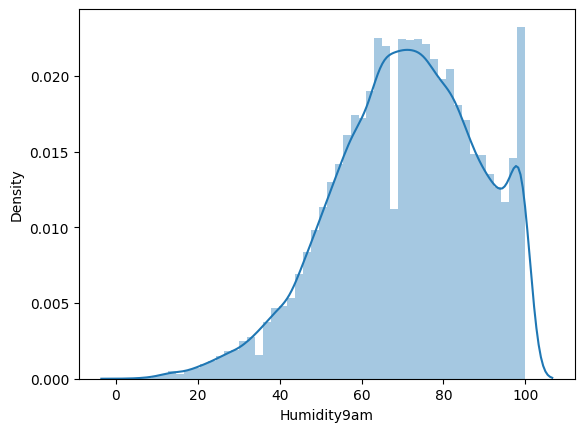

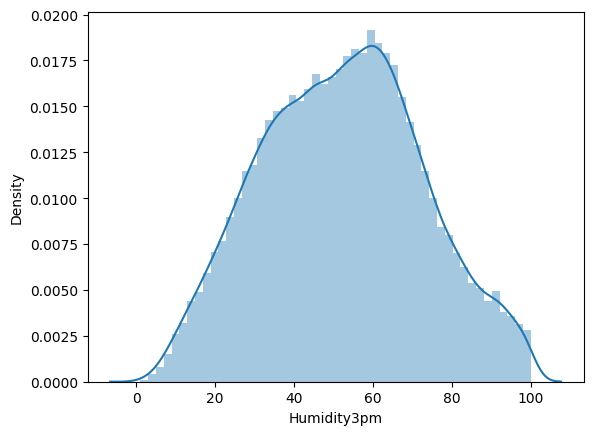

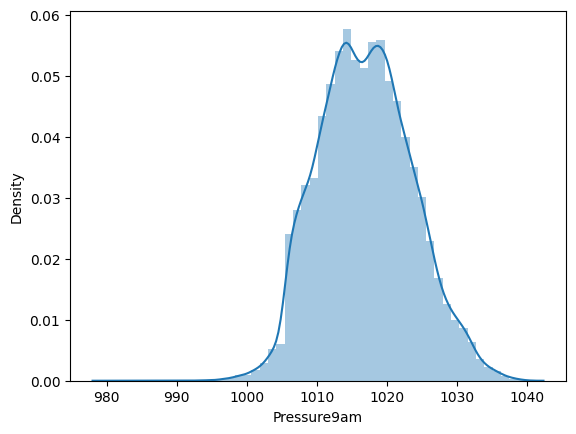

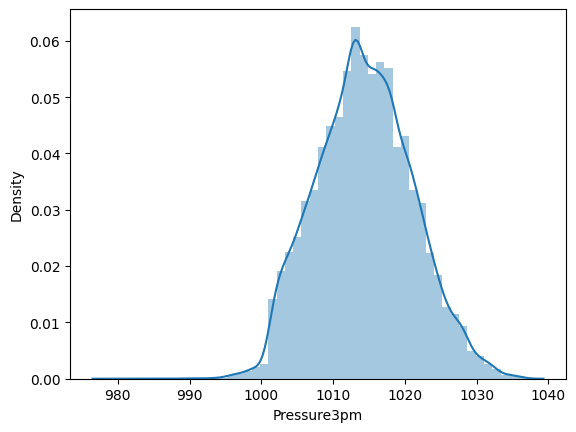

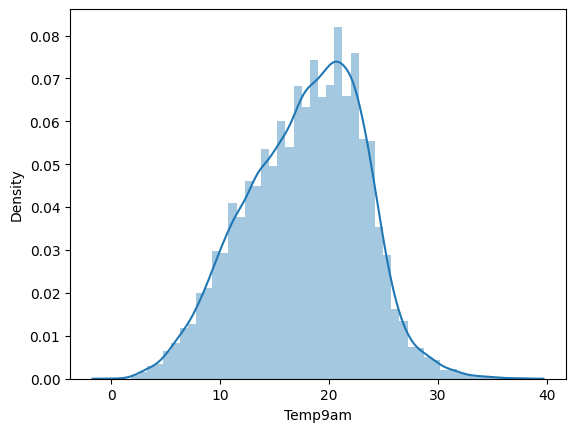

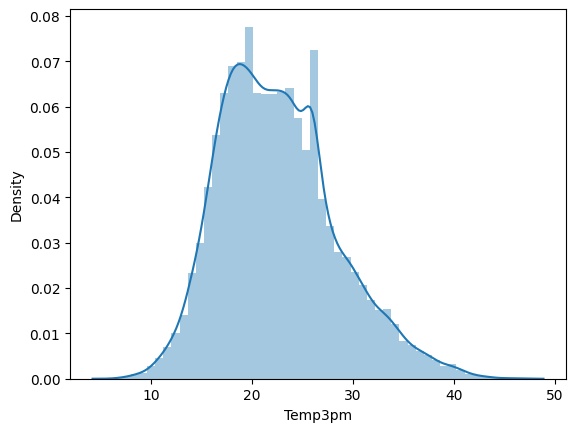

In [ ]:
for feature in wth_nd_continuous_feature:
  sb.distplot(wth_nd[feature])
  plt.show()

In [ ]:
# wth_nd = wth_nd[(np.abs(stats.zscore(wth_nd)) < 3).all(axis=1)]

### С помощью IQR

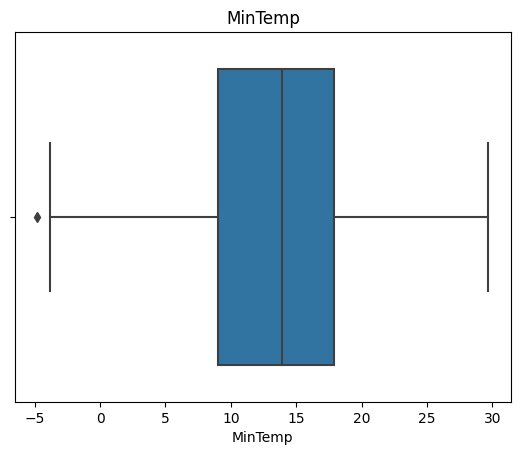

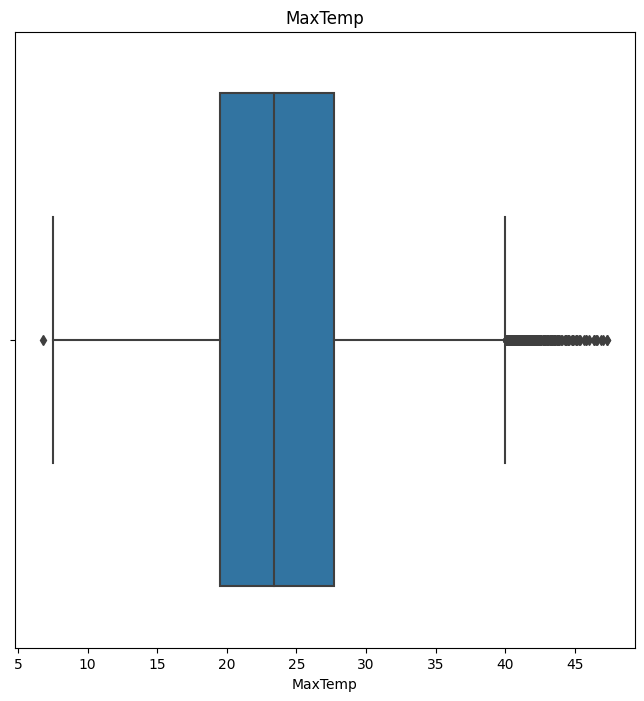

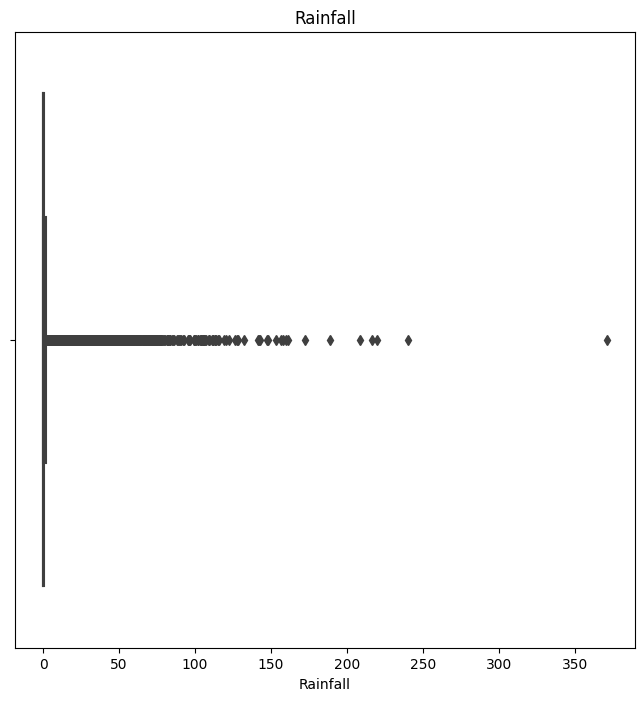

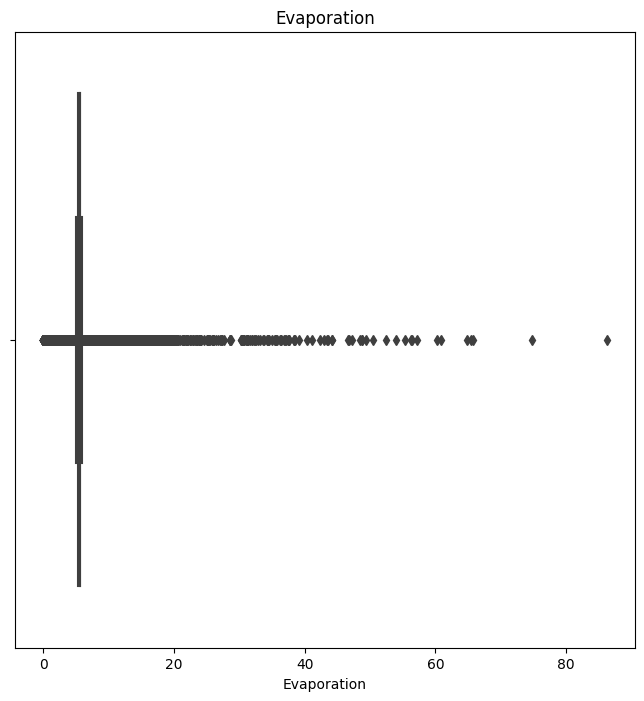

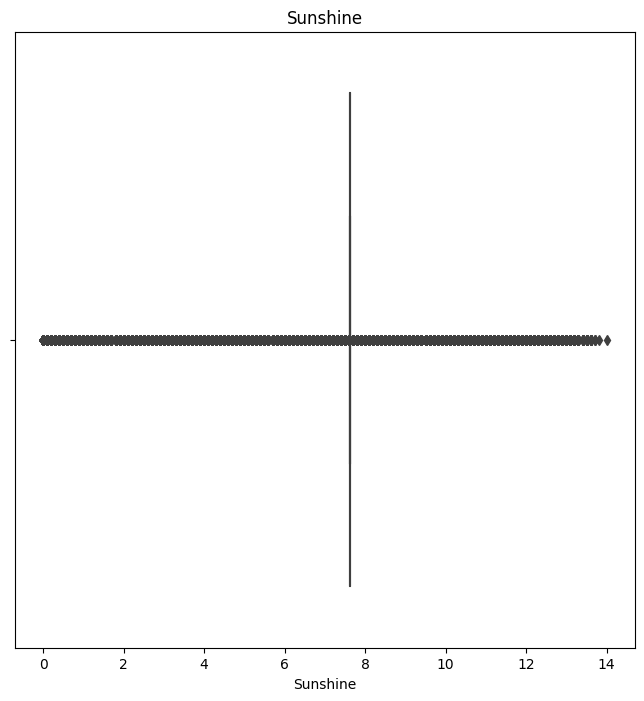

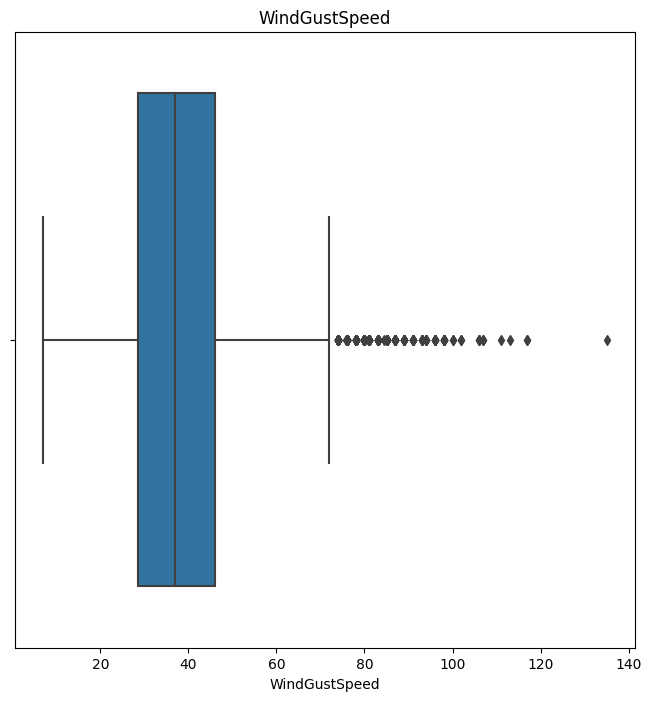

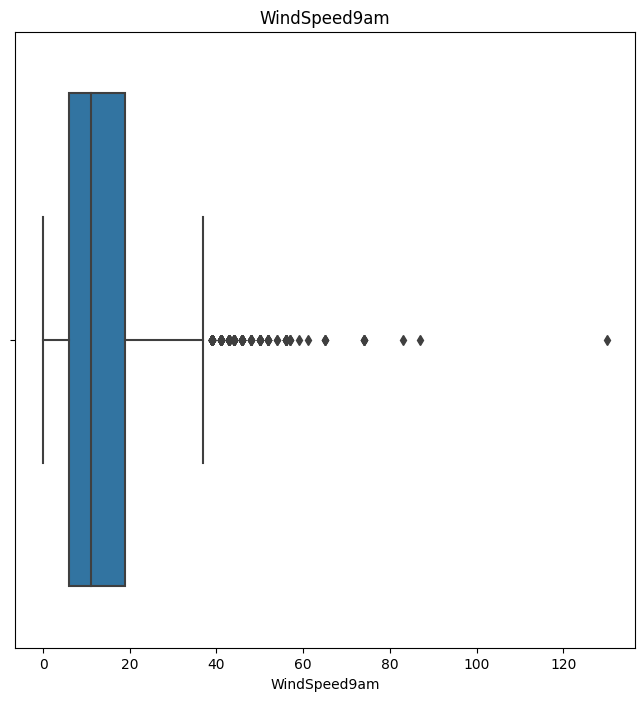

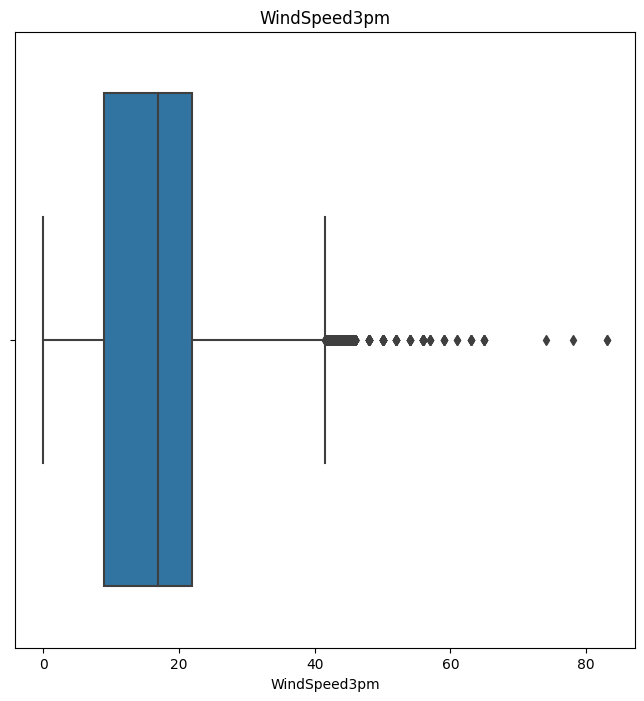

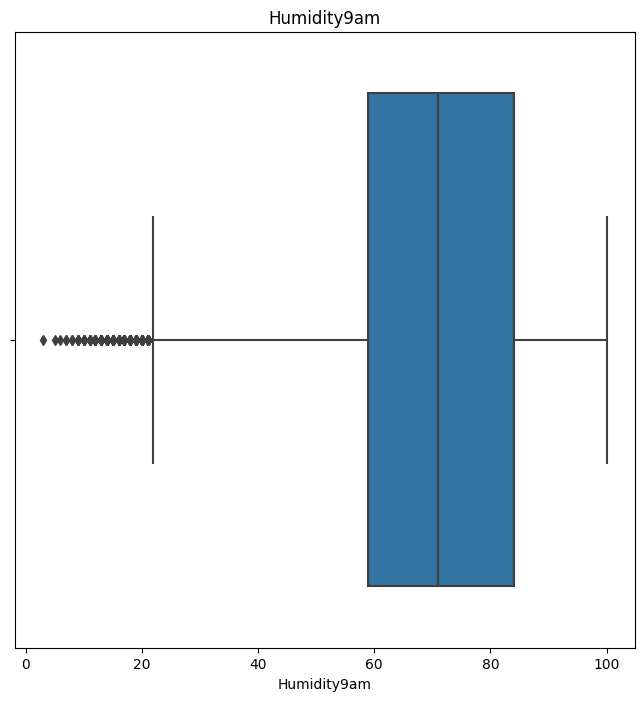

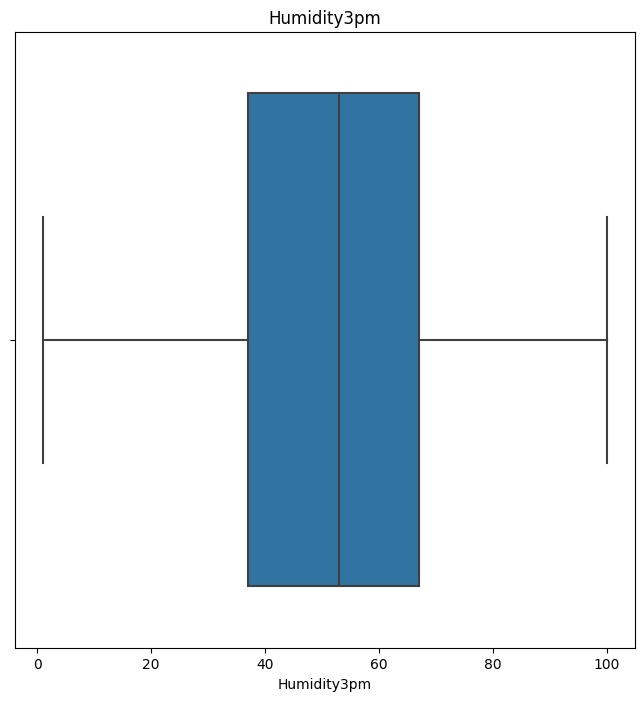

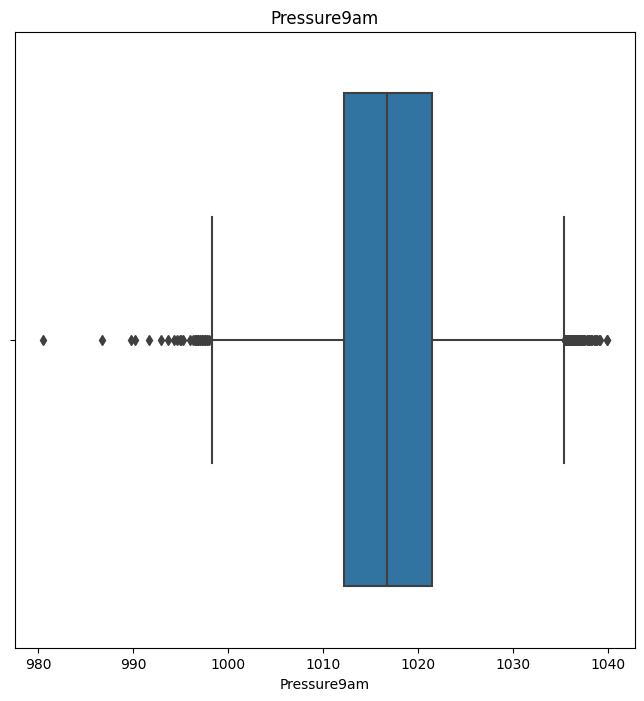

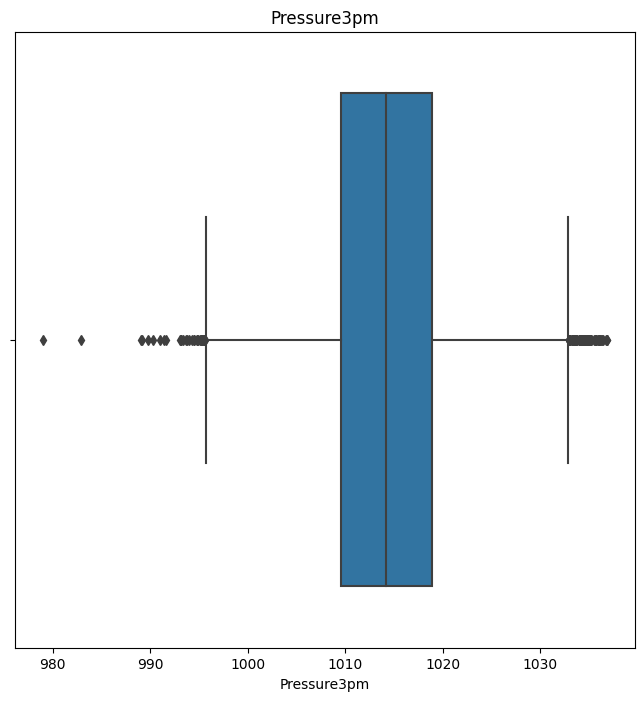

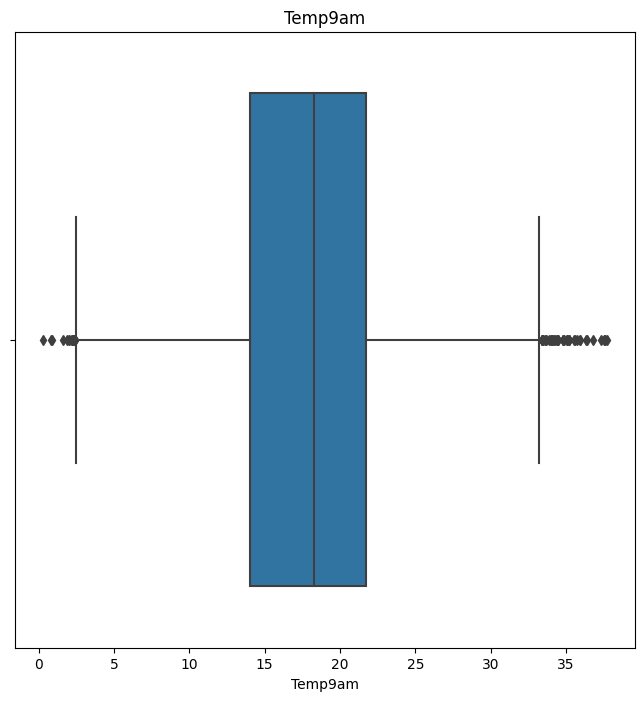

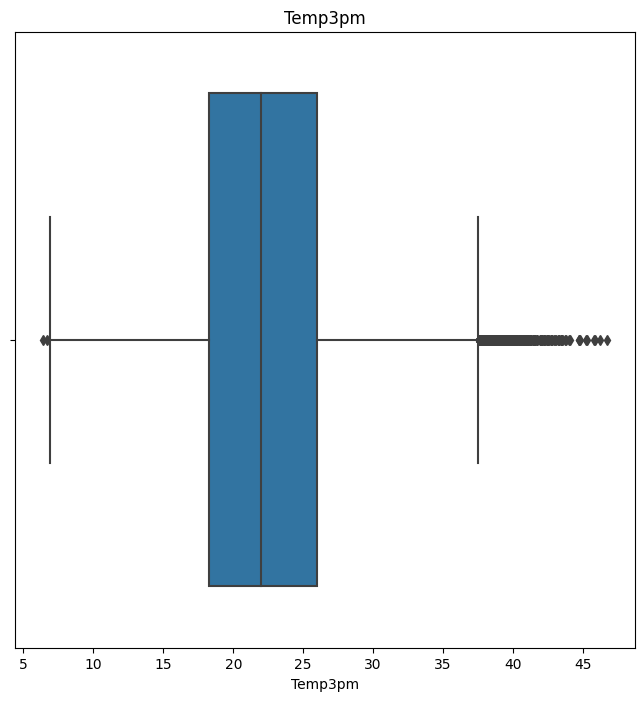

<Figure size 800x800 with 0 Axes>

In [ ]:
# Боксплоты

for feature in wth_nd_continuous_feature:
  sb.boxplot(x=wth_nd[feature])
  plt.title(feature)
  plt.figure(figsize=(8,8))

In [ ]:
def rem_outl(df,feature):
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3-Q1
  Lower_Limit = Q1-(3*IQR)
  Upper_Limit = Q3+(3*IQR)
  to_remove = df[(df[feature]<Lower_Limit)|(df[feature]>Upper_Limit)]
  labels_list = to_remove.index
  df = df.drop(labels=labels_list,axis=0)
  return df

In [ ]:
wth_nd = rem_outl(wth_nd,"MinTemp")
wth_nd = rem_outl(wth_nd,"MaxTemp")
wth_nd = rem_outl(wth_nd,"Rainfall")
wth_nd = rem_outl(wth_nd,"Evaporation")
wth_nd = rem_outl(wth_nd,"WindGustSpeed")
wth_nd = rem_outl(wth_nd,"WindSpeed9am")
wth_nd = rem_outl(wth_nd,"WindSpeed3pm")
wth_nd = rem_outl(wth_nd,"Humidity9am")
wth_nd = rem_outl(wth_nd,"Humidity3pm")
wth_nd = rem_outl(wth_nd,"Pressure9am")
wth_nd = rem_outl(wth_nd,"Pressure3pm")
wth_nd = rem_outl(wth_nd,"Temp9am")
wth_nd = rem_outl(wth_nd,"Temp3pm")



### Проверка данных после удаления выбросов

In [ ]:
print('Shape of wth_nd after removing outliers', wth_nd.shape )

Shape of wth_nd after removing outliers (16117, 22)


# Анализ данных

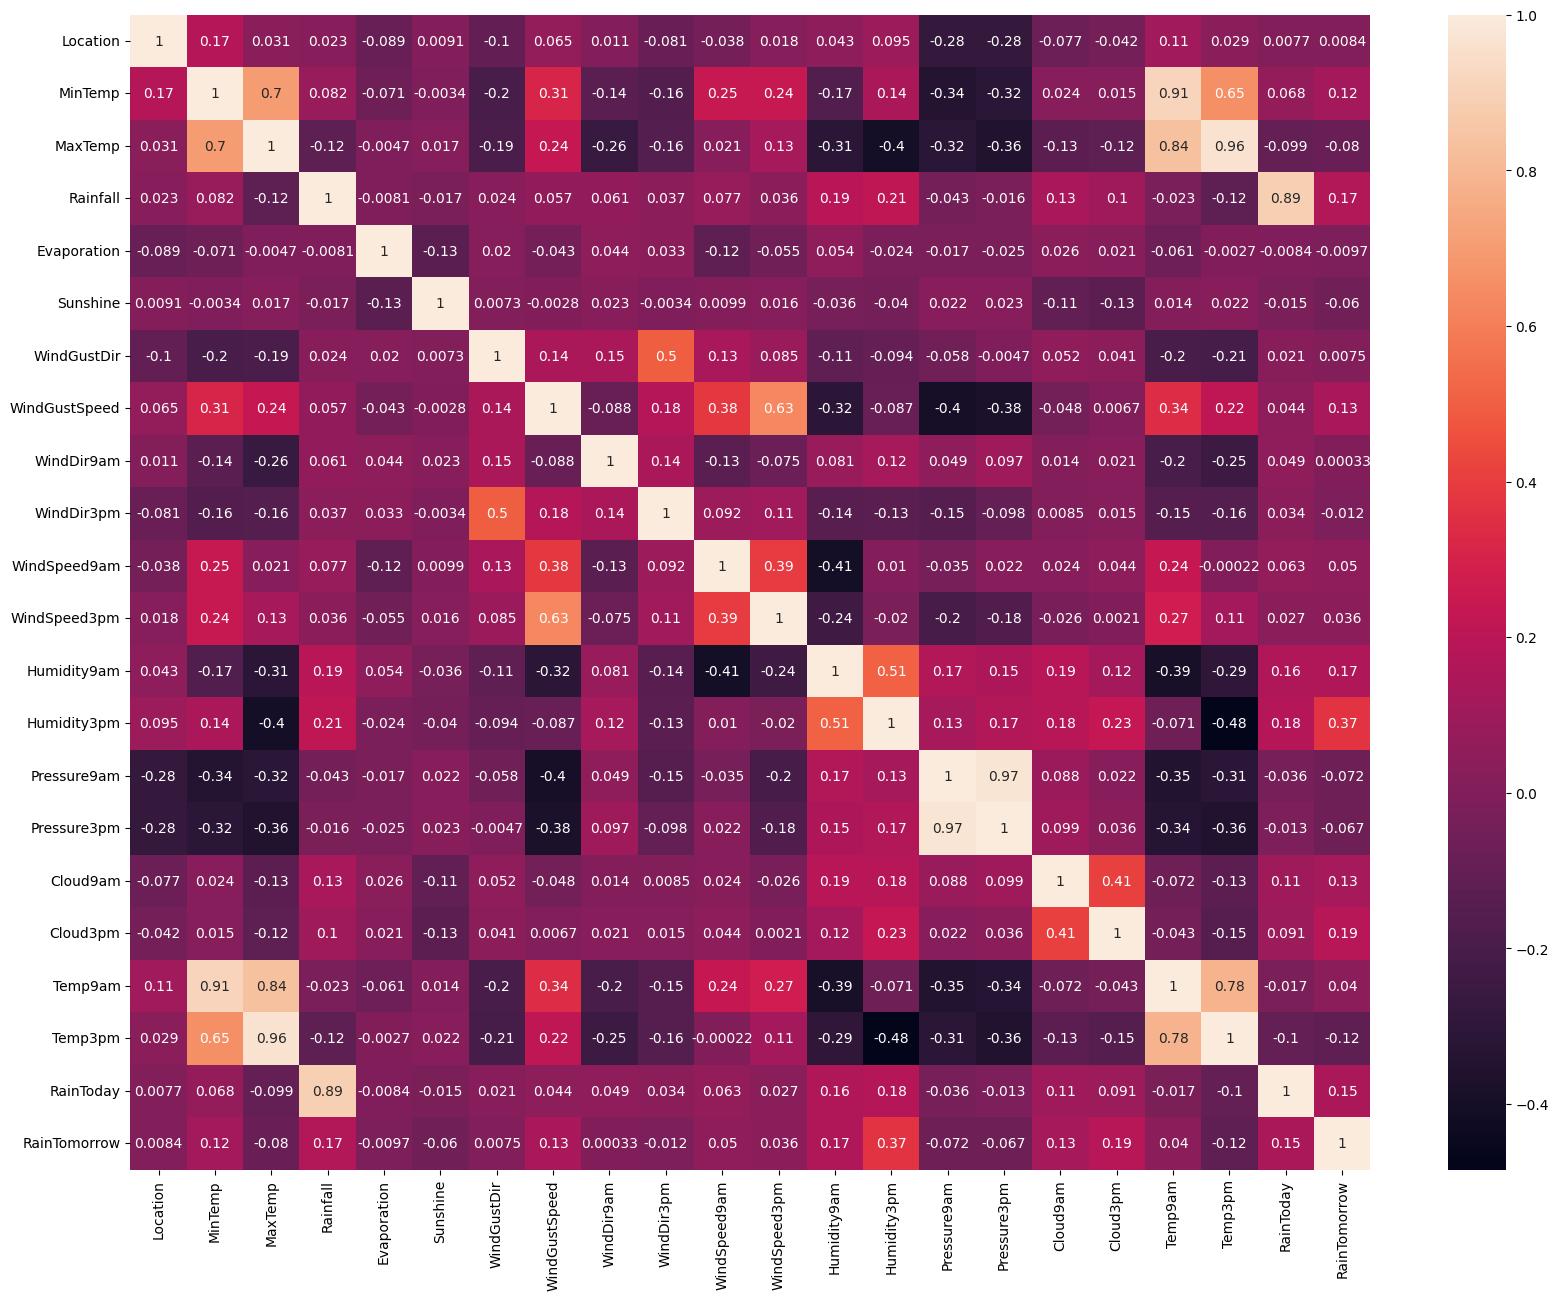

In [ ]:
plt.figure(figsize=(20,15))
sb.heatmap(wth_nd.corr(),annot=True)
plt.show()


Положительно коррелированные характеристики
1. Temp9am & MaxTemp
2. Temp3pm & MaxTemp
3. Temp9am & MinTemp
4. Rainfall & RainToday

Отрицательно коррелированные характеристики
1. MaxTemp & Humidity9am
2. MaxTemp & Humidity3pm
3. MaxTemp & Pressure9am
4. MaxTemp & Pressure3pm
5. MinTemp & Pressure9am
6. MinTemp & Pressure3pm
7. Sunshine & Cloud9am
8. Sunshine & Cloud3pm

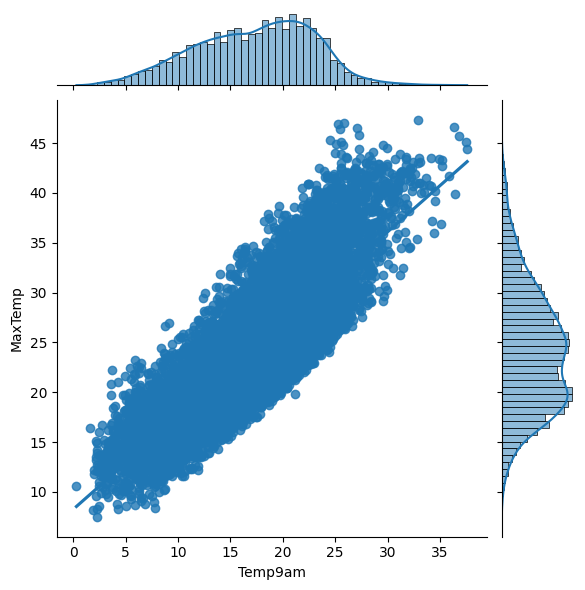

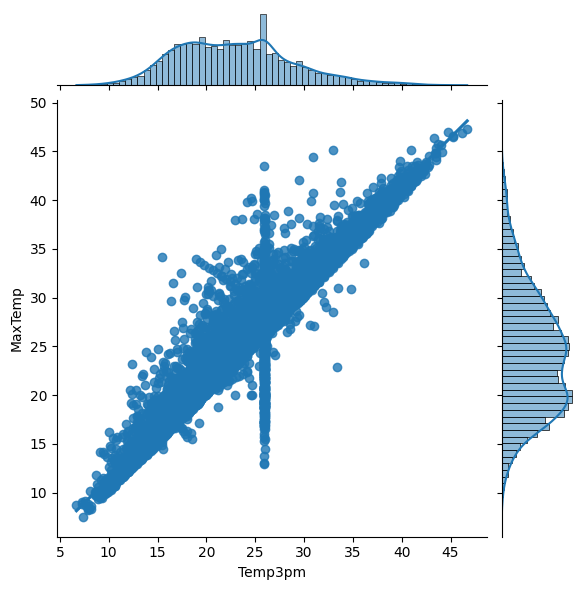

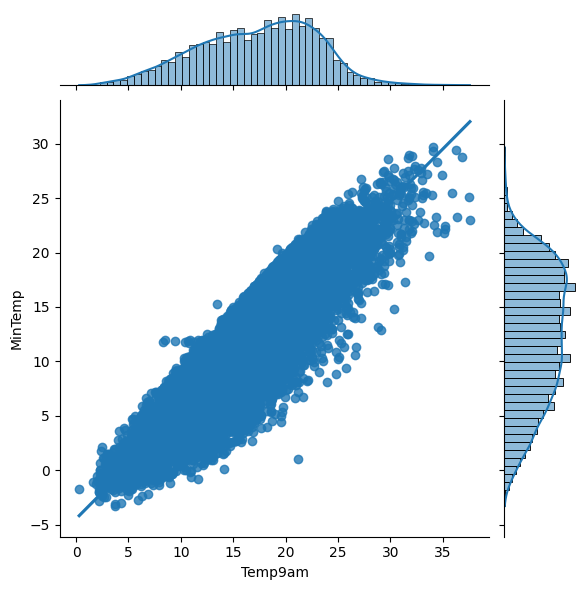

In [ ]:
sb.jointplot(data=wth_nd, x="Temp9am", y="MaxTemp", kind="reg")
sb.jointplot(data=wth_nd, x="Temp3pm", y="MaxTemp", kind="reg")
sb.jointplot(data=wth_nd, x="Temp9am", y="MinTemp", kind="reg")


# Создание функции для оценки модели

In [ ]:
def Mod_Eval(Model_name,y_test,y_pred):
  acc_score = accuracy_score(y_test,y_pred)
  conf_mat = confusion_matrix(y_test,y_pred)
  class_rep = classification_report(y_test,y_pred)
  print(f"{Model_name} : -")
  print(f"Accuracy of {Model_name} : {acc_score*100} %\n")
  print(f"Confusion Matrix of {Model_name} : \n{conf_mat}\n")
  print(f"Classification Report of {Model_name} : \n{class_rep}")


# Модели, требующие нормализации


## Нормализация


In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
X_unscaled = wth_nd.drop(["RainTomorrow"], axis=1)
y = wth_nd["RainTomorrow"]

In [ ]:
X_scaled = scaler.fit_transform(X_unscaled)

## Разделение Train test

In [ ]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_scaled,y,test_size =0.2)

## Модели

### Logistic Regression

In [ ]:
# Создание модели

Log_reg = LogisticRegression()

In [ ]:
# Обучение модели

t0=time.time()
Log_reg.fit(X_train_norm, y_train_norm)
t1=time.time()
print(f"Время, необходимое для обучения модели : {t1-t0} sec or {((t1-t0)/60)} min")

Time needed to train the model : 0.1700592041015625 sec or 0.002834320068359375 min


In [ ]:
# Предсказания по модели

t0=time.time()
y_pred = Log_reg.predict(X_test_norm)
t1=time.time()
print(f"Время, затраченное моделью на прогноз: {t1-t0} sec or {((t1-t0)/60)} min")

Time taken by model for prediction : 0.0018291473388671875 sec or 3.048578898111979e-05 min


In [ ]:
# Оценка модели
Mod_Eval("Logistic Regression",y_test_norm,y_pred)

Logistic Regression : -
Accuracy of Logistic Regression : 85.94913151364764 %

Confusion Matrix of Logistic Regression : 
[[2611   55]
 [ 398  160]]

Classification Report of Logistic Regression : 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2666
           1       0.74      0.29      0.41       558

    accuracy                           0.86      3224
   macro avg       0.81      0.63      0.67      3224
weighted avg       0.85      0.86      0.83      3224




### Машина опорных векторов (SVM)

In [ ]:
# Создание модели

SVM = svm.SVC()

In [ ]:
# Обучение модели

t0=time.time()
SVM.fit(X_train_norm,y_train_norm)
t1=time.time()
print(f"Время, необходимое для обучения модели: {t1-t0} sec or {((t1-t0)/60)} min")

Time needed to train the model : 8.506792783737183 sec or 0.14177987972895303 min


In [ ]:
# Предсказания по модели

t0=time.time()
y_pred = SVM.predict(X_test_norm)
t1=time.time()
print(f"Время, затраченное моделью на прогноз : {t1-t0} sec or {((t1-t0)/60)} min")

Time taken by model for prediction : 1.7362866401672363 sec or 0.02893811066945394 min


In [ ]:
# Оценка модели

Mod_Eval("Support Vector Machine",y_test_norm,y_pred)

Support Vector Machine : -
Accuracy of Support Vector Machine : 86.41439205955335 %

Confusion Matrix of Support Vector Machine : 
[[2635   31]
 [ 407  151]]

Classification Report of Support Vector Machine : 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      2666
           1       0.83      0.27      0.41       558

    accuracy                           0.86      3224
   macro avg       0.85      0.63      0.67      3224
weighted avg       0.86      0.86      0.83      3224




# Другие модели

## Разделение Train Test

In [ ]:
X = wth_nd.drop(["RainTomorrow"], axis=1)
y = wth_nd["RainTomorrow"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2)

## Модели

### Древо решений

In [ ]:
# Создание модели

Dec_tree = DecisionTreeClassifier(criterion="entropy")

In [ ]:
# Обучение модели

t0=time.time()
Dec_tree.fit(X_train,y_train)
t1=time.time()
print(f"Время, необходимое для обучения модели : {t1-t0} sec or {((t1-t0)/60)} min")

Time needed to train the model : 0.30734777450561523 sec or 0.005122462908426921 min


In [ ]:
# Предсказания по модели

t0=time.time()
y_pred = Dec_tree.predict(X_test)
t1=time.time()
print(f"Время, затраченное моделью на прогноз : {t1-t0} sec or {((t1-t0)/60)} min")

Time taken by model for prediction : 0.012270927429199219 sec or 0.0002045154571533203 min


In [ ]:
# Оценка модели

Mod_Eval("Decission True",y_test,y_pred)

Decission True : -
Accuracy of Decission True : 80.14888337468983 %

Confusion Matrix of Decission True : 
[[2358  336]
 [ 304  226]]

Classification Report of Decission True : 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2694
           1       0.40      0.43      0.41       530

    accuracy                           0.80      3224
   macro avg       0.64      0.65      0.65      3224
weighted avg       0.81      0.80      0.80      3224



### Классификатор случайного леса (RFC)

In [ ]:
# Создание модели
Ran_tree=RandomForestClassifier(criterion="entropy")

In [ ]:
# Обучение модели

t0=time.time()
Ran_tree.fit(X_train,y_train)
t1=time.time()
print(f"Время, необходимое для обучения модели : {t1-t0} sec or {((t1-t0)/60)} min")

Time needed to train the model : 2.9967939853668213 sec or 0.04994656642278036 min


In [ ]:
# Предсказания по модели

t0=time.time()
y_pred=Ran_tree.predict(X_test)
t1=time.time()
print(f"Время, затраченное моделью на прогноз : {t1-t0} sec or {((t1-t0)/60)} min")

Time taken by model for prediction : 0.11815905570983887 sec or 0.001969317595163981 min


In [ ]:
# Оценка модели

Mod_Eval("Random Forest Classifier",y_test,y_pred)

Random Forest Classifier : -
Accuracy of Random Forest Classifier : 86.66253101736973 %

Confusion Matrix of Random Forest Classifier : 
[[2631   63]
 [ 367  163]]

Classification Report of Random Forest Classifier : 
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      2694
           1       0.72      0.31      0.43       530

    accuracy                           0.87      3224
   macro avg       0.80      0.64      0.68      3224
weighted avg       0.85      0.87      0.84      3224



### XGBoost Classifier

In [ ]:
# Создание модели

xgb = XGBClassifier()

In [ ]:
# Обучение модели

t0=time.time()
xgb.fit(X_train,y_train)
t1=time.time()
print(f"Время, необходимое для обучения модели : {t1-t0} sec or {((t1-t0)/60)} min")

Time needed to train the model : 0.8698544502258301 sec or 0.0144975741704305 min


In [ ]:
# Предскааания по модели

t0=time.time()
y_pred = xgb.predict(X_test)
t1=time.time()
print(f"Время, затраченное моделью на прогноз : {t1-t0} sec or {((t1-t0)/60)} min")

Time taken by model for prediction : 0.040120840072631836 sec or 0.0006686806678771973 min


In [ ]:
# Оценка модели

Mod_Eval("XGBoost Classifier",y_test,y_pred)

XGBoost Classifier : -
Accuracy of XGBoost Classifier : 86.66253101736973 %

Confusion Matrix of XGBoost Classifier : 
[[2585  109]
 [ 321  209]]

Classification Report of XGBoost Classifier : 
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2694
           1       0.66      0.39      0.49       530

    accuracy                           0.87      3224
   macro avg       0.77      0.68      0.71      3224
weighted avg       0.85      0.87      0.85      3224



### CatBoost Classifier

In [ ]:
# Создание модели

cat_boost = CatBoostClassifier()

In [ ]:
# Модель обучения

t0=time.time()
cat_boost.fit(X_train, y_train)
t1=time.time()
print(f"Время, необходимое для обучения модели : {t1-t0} sec or {((t1-t0)/60)} min")

Learning rate set to 0.030694
0:	learn: 0.6714961	total: 100ms	remaining: 1m 40s
1:	learn: 0.6501285	total: 150ms	remaining: 1m 14s
2:	learn: 0.6291603	total: 184ms	remaining: 1m 1s
3:	learn: 0.6106145	total: 224ms	remaining: 55.9s
4:	learn: 0.5930927	total: 266ms	remaining: 53s
5:	learn: 0.5775754	total: 306ms	remaining: 50.7s
6:	learn: 0.5635107	total: 354ms	remaining: 50.3s
7:	learn: 0.5489861	total: 443ms	remaining: 55s
8:	learn: 0.5372447	total: 469ms	remaining: 51.6s
9:	learn: 0.5259514	total: 512ms	remaining: 50.7s
10:	learn: 0.5140776	total: 556ms	remaining: 50s
11:	learn: 0.5038362	total: 590ms	remaining: 48.6s
12:	learn: 0.4945527	total: 630ms	remaining: 47.8s
13:	learn: 0.4845259	total: 664ms	remaining: 46.7s
14:	learn: 0.4764131	total: 693ms	remaining: 45.5s
15:	learn: 0.4689227	total: 736ms	remaining: 45.3s
16:	learn: 0.4623719	total: 755ms	remaining: 43.6s
17:	learn: 0.4547259	total: 779ms	remaining: 42.5s
18:	learn: 0.4477792	total: 798ms	remaining: 41.2s
19:	learn: 0.44

In [ ]:
# Предскааания по модели

t0=time.time()
y_pred = cat_boost.predict(X_test)
t1=time.time()
print(f"Время, затраченное моделью на прогноз : {t1-t0} sec or {((t1-t0)/60)} min")

Time taken by model for prediction : 0.015526771545410156 sec or 0.00025877952575683596 min


In [ ]:
# Оценка модели

Mod_Eval("CatBoost Classifier",y_test,y_pred)

CatBoost Classifier : -
Accuracy of CatBoost Classifier : 87.43796526054591 %

Confusion Matrix of CatBoost Classifier : 
[[2623   71]
 [ 334  196]]

Classification Report of CatBoost Classifier : 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2694
           1       0.73      0.37      0.49       530

    accuracy                           0.87      3224
   macro avg       0.81      0.67      0.71      3224
weighted avg       0.86      0.87      0.86      3224



# Прогнозы Конвертация в CSV

Прогнозы классификатора CatBoost можно снова преобразовать в CSV

In [ ]:
y_test = le_rain_tom.inverse_transform(y_test)
y_pred = le_rain_tom.inverse_transform(y_pred)

In [ ]:
print(y_test)

['Yes' 'No' 'No' ... 'No' 'No' 'No']


In [ ]:
print(y_pred)

['No' 'No' 'No' ... 'No' 'No' 'No']


In [ ]:
y_test = y_test.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [ ]:
con = np.concatenate((y_test,y_pred),axis=1)
wth_result = pd.DataFrame(con,columns=["Original","Prediction"])

In [ ]:
wth_result.head(15)

,Original,Prediction
0,Yes,No
1,No,No
2,No,No
3,Yes,No
4,No,No
5,No,No
6,No,No
7,No,No
8,No,No
9,Yes,No


In [ ]:
wth_result.to_csv("CatPred.csv")

# Выбор моделей и прогнозирование с их помощью

In [ ]:
# Функция для pickle модели

def Mod_pkl(model_name,model):
  pickle.dump(model,open(f"{model_name}.pkl",'wb'))

In [ ]:
# Функция для загрузки pickle модели

def Load_pkl(model_name,model):
   return pickle.load(open(f"/content/{model_name}.pkl",'rb')) # For Google Colab
  # return pickle.load(open(f"/pickles/{model_name}.pkl",'rb')) # For Local Device

In [ ]:
# Функция для прогнозирования на основе pickle модели

def pkl_pred(model_name,model,data):

  def Load_pkl(model_name,model):
    return pickle.load(open(f"/content/{model_name}.pkl",'rb')) # For Google Colab
  # return pickle.load(open(f"/pickles/{model_name}.pkl",'rb')) # For Local Device

  loaded_model = Load_pkl(model_name,model)

  try:
    array = np.array(data)
    array = array.reshape(1,-1)
  except:
    array = data.reshape(1,-1)

  prediction = Load_pkl(model_name,model).predict(array)
  pred = le_rain_tom.inverse_transform(prediction)
  print(f"{(pred)[0]} or {(prediction)[0]}")
  try:
    if prediction==0:
      print("Завтра будет солнечный день")
    else:
      print("Завтра будет дождь")
  except:
    if pred=="No":
      print("Завтра будет солнечный день")
    else:
      print("Завтра будет дождь")

Предсказания

In [ ]:
test_row = wth.iloc[2255,1:-1]
test_row

Location           Albury
MinTemp               7.5
MaxTemp              23.7
Rainfall              0.0
Evaporation      5.614676
Sunshine         7.623433
WindGustDir             W
WindGustSpeed        22.0
WindDir9am              N
WindDir3pm              W
WindSpeed9am          2.0
WindSpeed3pm         13.0
Humidity9am          85.0
Humidity3pm          37.0
Pressure9am        1019.1
Pressure3pm        1015.6
Cloud9am         4.316282
Cloud3pm         4.425554
Temp9am              13.5
Temp3pm              23.2
RainToday              No
Name: 2255, dtype: object

In [ ]:
test_row["Location"] = le_loc.transform([test_row["Location"]])[0]
test_row["WindGustDir"] = le_wind_gust.transform([test_row["WindGustDir"]])[0]
test_row["WindDir9am"] = le_dir9.transform([test_row["WindDir9am"]])[0]
test_row["WindDir3pm"] = le_dir3.transform([test_row["WindDir3pm"]])[0]
test_row["RainToday"] = le_rain_tod.transform([test_row["RainToday"]])[0]

In [ ]:
pkl_pred("cat",cat_boost,test_row)

No or 0
It will be sunny day tomorrow.


In [ ]:
# Исходное значение

wth.iloc[2255,-1]

'No'

# Заключение

Модели с высочайшей точностью и работой за меньшее время:
1. Классификатор CatBoost
2. Классификатор XgBoost
3. Классификатор случайного леса